# **Optimization project**

In [ ]:
# === Imports of libraries and useful functions ===
####################################################

# Inline plotting (for Jupyter notebooks)
%matplotlib inline
import matplotlib.pyplot as plt

# Math functions
from math import sqrt      # Square root
from math import ceil      # Ceiling (round up)
from math import log       # Logarithm

# NumPy - Vector and matrix operations
import numpy as np         # NumPy library
from numpy.random import multivariate_normal, randn, uniform  # Random distributions

# SciPy - Efficient mathematical computations
from scipy.linalg import toeplitz      # Toeplitz matrix
from scipy.linalg import norm          # Euclidean norm (related to inner product)
from scipy.linalg import svdvals       # Singular value decomposition (returns singular values)
from scipy.linalg import qr            # QR decomposition of a matrix
from scipy.optimize import fmin_l_bfgs_b  # Efficient optimization method (L-BFGS-B algorithm)

# **1- Matrix Variables and Optimization**

Dans cette partie, nous considérons un problème de régression linéaire basique, pour lequel on se donne $X = [x] \in \mathbb{R}^{n \times 1}$ avec $x$ un vecteur non nul et $y \in \mathbb{R}^n$. Dans sa forme classique, le problème de régression linéaire consiste alors à déterminer $w \in \mathbb{R}$ tel que $Xw = wx \approx y$. Cela s'écrit comme le problème de régression linéaire suivant :

$$
\min_{w \in \mathbb{R}} \frac{1}{2n} \| wx - y \|^2. \quad (1)
$$

**Question 1 :**


**b) Reprenons le code de régression linéaire et de descente de gradient vu durant la première séance de TP, et vérifier que l’algorithme converge vers une solution lorsque $x$ et $y$ sont générés selon une loi normale $N(0, I)$ (cf. notebook sur la descente de gradient).**


Dans cette partie, nous abordons un problème de régression linéaire scalaire où nous cherchons à déterminer un scalaire $w \in \mathbb{R}$ tel que $wx \approx y$. Pour cela, nous minimisons la fonction objectif $f(w) = \frac{1}{2n} \| wx - y \|^2$.

Nous avons généré des données $x$ et $y$ selon une loi normale $N(0, I)$ avec $n = 1000$ échantillons. Ces données servent de base pour tester notre algorithme d'optimisation.

Nous avons par la suite implémenté une classe `ScalarRegression` pour définir le problème de régression, incluant la fonction objectif (erreur quadratique moyenne) et son gradient. Ensuite, nous avons mis en œuvre une descente de gradient pour minimiser cette fonction. L'algorithme est initialisé avec $w_0 = 0$ et utilise un taux d'apprentissage de 0.1 sur 200 itérations. La convergence de l'algorithme est vérifiée en comparant la solution obtenue avec la solution analytique, et la décroissance de la fonction objectif est visualisée pour confirmer l'efficacité de l'approche.


Iteration   0 : f(w) = 5.3086e-01, grad = -2.3146e-02, w = 0.002315
Iteration  50 : f(w) = 5.3058e-01, grad = -1.4574e-04, w = 0.023877
Iteration 100 : f(w) = 5.3058e-01, grad = -9.1771e-07, w = 0.024013
Iteration 150 : f(w) = 5.3058e-01, grad = -5.7785e-09, w = 0.024014

Analytical solution  : w* = 0.024014
GD solution           : w  = 0.024014


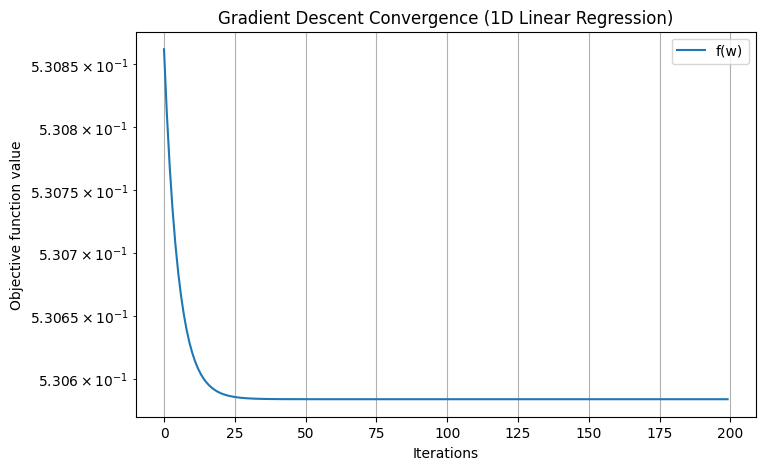

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

# -----------------------------
# Data generation: x, y ~ N(0, I)
# -----------------------------
np.random.seed(1)
n = 1000
x = np.random.randn(n)  # x ∈ ℝⁿ (feature vector)
y = np.random.randn(n)  # y ∈ ℝⁿ (target vector)

# -----------------------------
# Scalar Linear Regression Problem: minimize (1/2n) * ||w * x - y||^2
# -----------------------------
class ScalarRegression:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n = len(x)

    def fun(self, w):
        # Objective function: MSE
        return norm(w * self.x - self.y) ** 2 / (2 * self.n)

    def grad(self, w):
        # Gradient of the objective
        return np.dot(self.x, (w * self.x - self.y)) / self.n

# -----------------------------
# Gradient Descent (TP-style)
# -----------------------------
def gd(w0, problem, stepsize, n_iter=200, verbose=True):
    w = w0
    obj_vals = []

    for k in range(n_iter):
        obj = problem.fun(w)
        obj_vals.append(obj)
        g = problem.grad(w)
        w -= stepsize * g

        if verbose and k % 50 == 0:
            print(f"Iteration {k:3d} : f(w) = {obj:.4e}, grad = {g:.4e}, w = {w:.6f}")

    return w, np.array(obj_vals)

# -----------------------------
# Execution
# -----------------------------
problem = ScalarRegression(x, y)
w0 = 0.0
stepsize = 0.1
n_iter = 200

w_final, obj_vals = gd(w0, problem, stepsize, n_iter)

# -----------------------------
# Compare with analytical solution
# -----------------------------
w_star = np.dot(x, y) / np.dot(x, x)
print("\nAnalytical solution  : w* =", round(w_star, 6))
print("GD solution           : w  =", round(w_final, 6))

# -----------------------------
# Plot convergence of the objective
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(obj_vals, label="f(w)")
plt.xlabel("Iterations")
plt.ylabel("Objective function value")
plt.title("Gradient Descent Convergence (1D Linear Regression)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()


Comme vu en cours, une solution du problème (1) n’est pas nécessairement une solution du système linéaire $wx = y$. Dans le cas qui nous intéresse, cela ne peut être vrai que si les vecteurs $x$ et $y$ sont colinéaires. Cependant, on peut chercher à surparamétrer le problème en cherchant à calculer une matrice $W \in \mathbb{R}^{n \times n}$ telle que $Wx = y$. Cela conduit à formuler le problème :

$$
\min_{W \in \mathbb{R}^{n \times n}} f(W) := \frac{1}{2n} \| Wx - y \|^2.
$$

**b) Adaptons le code de descente de gradient de la question 1 au problème (2) et comparer les résultats à ceux de la question 1 pour les mêmes données $(x, y)$.**

**NB :** On pourra utiliser la formule de la dérivée de $f$ par rapport à $W$ vue dans le notebook sur la différentiation automatique, et considérer que l’itération de descente de gradient s’écrit :

$$
W_{k+1} = W_k - \alpha_k \nabla_W f(W_k).
$$


**Réponse:**

Dans cette partie, nous explorons une approche différente pour résoudre le problème de régression linéaire en surparamétrant le modèle. Au lieu de chercher un scalaire $w \in \mathbb{R}$, nous cherchons à calculer une matrice $W \in \mathbb{R}^{n \times n}$ telle que $Wx = y$. Cela conduit à la formulation du problème d'optimisation suivant :

$$\min_{W \in \mathbb{R}^{n \times n}} f(W) := \frac{1}{2n} \| Wx - y \|^2.$$

Nous avons adapté le code de descente de gradient utilisé précédemment pour résoudre ce nouveau problème. La classe `MatrixRegression` définit le problème de régression matricielle, incluant la fonction objectif et son gradient. Nous avons ensuite implémenté une descente de gradient pour minimiser cette fonction.

L'algorithme est initialisé avec une matrice $W_0$ de zéros et utilise un taux d'apprentissage de 0.1 sur 200 itérations. Nous comparons les résultats obtenus avec ceux de la régression scalaire pour les mêmes données $(x, y)$. La convergence de l'algorithme est visualisée en traçant la décroissance de la fonction objectif pour les deux approches, ce qui permet de comparer leur efficacité.

In [ ]:
# -----------------------------
# Matrix Problem: minimize (1/2n) * ||Wx - y||^2
# -----------------------------
class MatrixRegression:
    def __init__(self, x, y):
        self.x = x.reshape(-1, 1)  # x ∈ ℝⁿ → (n,1)
        self.y = y.reshape(-1, 1)
        self.n = len(x)

    def fun(self, W):
        diff = W @ self.x - self.y
        return norm(diff)**2 / (2 * self.n)

    def grad(self, W):
        diff = W @ self.x - self.y
        return (diff @ self.x.T) / self.n  # gradient = (n×1) @ (1×n)


In [ ]:
# -----------------------------
# Matrix Gradient Descent
# -----------------------------
def gd_matrix(W0, problem, stepsize, n_iter=200, verbose=True):
    W = W0.copy()
    obj_vals = []

    for k in range(n_iter):
        obj = problem.fun(W)
        obj_vals.append(obj)
        grad = problem.grad(W)
        W -= stepsize * grad

        if verbose and k % 50 == 0:
            print(f"Iteration {k:3d} : f(W) = {obj:.4e}, ||grad|| = {norm(grad):.4e}")

    return W, np.array(obj_vals)

In [ ]:
# -----------------------------
# Execution (question 2)
# -----------------------------
W0 = np.zeros((n, n))  # Initialization
problem_matrix = MatrixRegression(x, y)
W_final, obj_vals_matrix = gd_matrix(W0, problem_matrix, stepsize=0.1, n_iter=200)

Iteration   0 : f(W) = 5.3086e-01, ||grad|| = 1.0116e+00
Iteration  50 : f(W) = 2.1048e-05, ||grad|| = 6.3698e-03
Iteration 100 : f(W) = 8.3449e-10, ||grad|| = 4.0109e-05
Iteration 150 : f(W) = 3.3086e-14, ||grad|| = 2.5255e-07


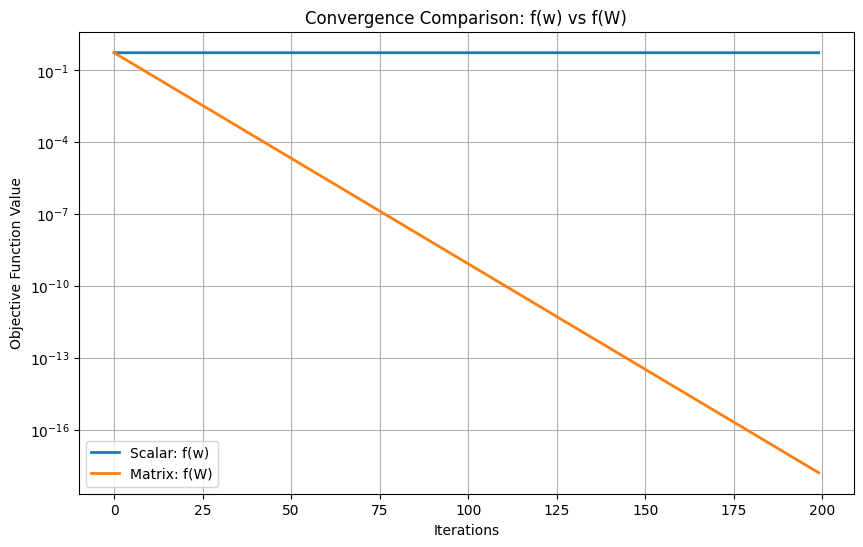

In [ ]:
# Comparison of f(w) (Question 1) vs f(W) (Question 2)
plt.figure(figsize=(10, 6))
plt.plot(obj_vals, label="Scalar: f(w)", linewidth=2)
plt.plot(obj_vals_matrix, label="Matrix: f(W)", linewidth=2)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Objective Function Value")
plt.title("Convergence Comparison: f(w) vs f(W)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
residu_matrix = norm(W_final @ x.reshape(-1, 1) - y.reshape(-1, 1))**2

print("\n=== Compared Results ===")
print("Analytical Solution (Scalar)     : w* =", round(w_star, 6))
print("GD Solution (Scalar)             : w  =", round(w_final, 6))
print("Residual ||Wx - y||² (Matrix)    :", round(residu_matrix, 6))


=== Compared Results ===
Analytical Solution (Scalar)     : w* = 0.024014
GD Solution (Scalar)             : w  = 0.024014
Residual ||Wx - y||² (Matrix)    : 0.0


## **2-Factorisation matricielle**

Dans cette partie, on prolonge l’étude précédente en considérant des problèmes de factorisation matricielle, pour lesquels le modèle est défini au moyen de deux matrices. Comme dans l’un des exercices vus en TD, on considère une matrice de données (a priori rectangulaire) $X \in \mathbb{R}^{n_1 \times n_2}$, dont on va chercher une approximation via une matrice de rang 1. En utilisant le fait qu’une matrice de rang 1 s’écrit toujours sous la forme $uv^T$ avec $u$ et $v$ des vecteurs, le problème de déterminer la meilleure approximation de rang 1 peut s’écrire :

$$\min_{u \in \mathbb{R}^{n_1}, v \in \mathbb{R}^{n_2}} \frac{1}{2n} \| uv^T - X \|^2 = \frac{1}{2n} \sum_{i=1}^{n_1} \sum_{j=1}^{n_2} ([u]_i[v]_j - [X]_{ij})^2.$$


**a) Générons une matrice $X = \bar{x}z^T \in \mathbb{R}^{10 \times 20}$ de rang 1 où $\bar{x}$ et $z$ sont des vecteurs générés selon une loi normale ${N}(0, I)$. Puis comparer l’algorithme du gradient stochastique basique et l’algorithme de descente de gradient sur le problème (3).**

**Remarque :** Dans l’implémentation, on pourra concaténer les vecteurs $u$ et $v$ dans un unique vecteur $w$ de taille $n_1 + n_2$.




Nous avons implémenté une classe `MatrixFactorization` pour définir le problème de factorisation matricielle, incluant la fonction objectif et son gradient. Ensuite, nous avons mis en œuvre deux algorithmes : la descente de gradient par lots (batch) et la descente de gradient stochastique (SGD). Ces algorithmes sont utilisés pour minimiser la fonction objectif et comparer leur efficacité en termes de convergence.

In [ ]:
# -----------------------------
# 1. Generation of the rank-1 matrix X = x̄ z̄ᵀ
# -----------------------------
np.random.seed(0)
n1, n2 = 10, 20
n = n1 * n2

x_bar = np.random.randn(n1)
z_bar = np.random.randn(n2)
X = np.outer(x_bar, z_bar)  # rank-1 matrix

In [ ]:
# -----------------------------
# Class for matrix factorization
# -----------------------------
class MatrixFactorization:
    def __init__(self, X):
        self.X = X
        self.n1, self.n2 = X.shape
        self.n = self.n1 * self.n2

    def unpack(self, w):
        u = w[:self.n1]
        v = w[self.n1:]
        return u, v

    def fun(self, w):
        u, v = self.unpack(w)
        R = np.outer(u, v) - self.X
        return np.sum(R ** 2) / (2 * self.n)

    def grad(self, w):
        u, v = self.unpack(w)
        R = np.outer(u, v) - self.X
        grad_u = R @ v / self.n
        grad_v = R.T @ u / self.n
        return np.concatenate([grad_u, grad_v])

In [ ]:
# -----------------------------
# Batch Gradient Descent
# -----------------------------
def gd_batch(w0, problem, stepsize=1.0, n_iter=300):
    w = w0.copy()
    obj_vals = []

    for _ in range(n_iter):
        obj_vals.append(problem.fun(w))
        grad = problem.grad(w)
        w -= stepsize * grad

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Stochastic Gradient Descent (SGD)
# -----------------------------
def sgd(w0, problem, stepsize=10.0, n_iter=10000):
    w = w0.copy()
    obj_vals = []
    n1, n2 = problem.n1, problem.n2

    for k in range(n_iter):
        i = np.random.randint(0, n1)
        j = np.random.randint(0, n2)

        u, v = problem.unpack(w)
        error = u[i] * v[j] - problem.X[i, j]

        grad_u = np.zeros_like(u)
        grad_v = np.zeros_like(v)
        grad_u[i] = error * v[j] / problem.n
        grad_v[j] = error * u[i] / problem.n

        grad = np.concatenate([grad_u, grad_v])
        w -= stepsize * grad

        if k % 100 == 0:
            obj_vals.append(problem.fun(w))

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Initialization and execution of algorithms
# -----------------------------

# Initialization of the vector [u; v]
w0 = np.random.randn(n1 + n2)
problem = MatrixFactorization(X)

# Classic gradient descent
w_gd, obj_gd = gd_batch(w0, problem, stepsize=1.0, n_iter=300)

# Stochastic gradient descent
w_sgd, obj_sgd = sgd(w0, problem, stepsize=10.0, n_iter=10000)


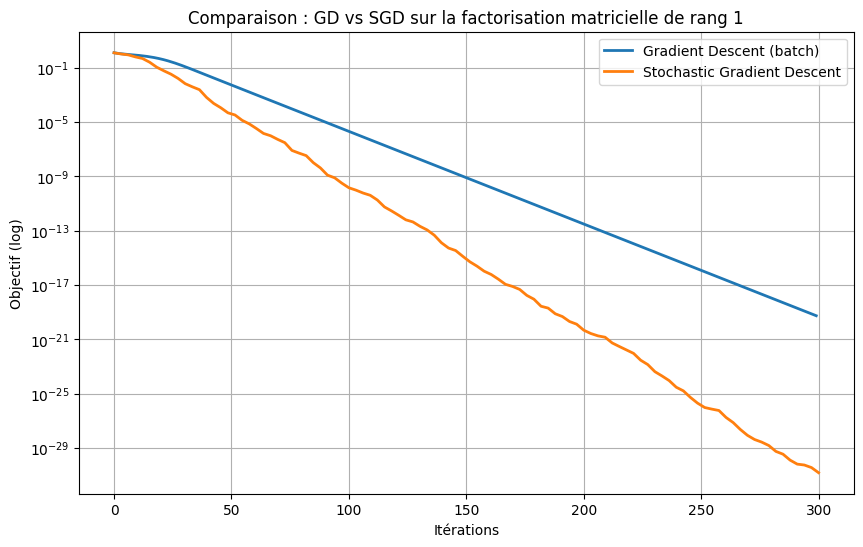

In [ ]:
# -----------------------------
# Visualization of results
# -----------------------------

plt.figure(figsize=(10, 6))
plt.plot(obj_gd, label="Gradient Descent (batch)", linewidth=2)
plt.plot(np.linspace(0, len(obj_gd), len(obj_sgd)), obj_sgd, label="Stochastic Gradient Descent", linewidth=2)
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Objectif (log)")
plt.title("Comparaison : GD vs SGD sur la factorisation matricielle de rang 1")
plt.grid(True)
plt.legend()
plt.show()

**b) Testons plusieurs valeurs de tailles de fournées (batch size) et en conclure une bonne valeur pour ce problème.**

Ce code implémente un problème de factorisation matricielle en utilisant la descente de gradient stochastique (SGD) avec différentes tailles de lots (batch sizes) pour comparer leur efficacité de convergence. Le processus commence par générer une matrice $X$ de rang 1 à partir de deux vecteurs normalement distribués. La classe `MatrixFactorization` définit la fonction objectif et son gradient, qui sont utilisés pour optimiser la factorisation. La fonction `mini_batch_sgd` effectue la SGD avec différentes tailles de lots, mettant à jour itérativement les vecteurs de factorisation $u$ et $v$.

Nous testons plusieurs tailles de lots (1, 5, 20, 100, 200) pour évaluer comment la taille du lot influence la convergence de l'algorithme. Ces intervalles sont choisis pour couvrir une gamme de petites à grandes tailles de lots, permettant d'observer les compromis entre la rapidité de convergence et la stabilité des mises à jour. Les résultats sont visualisés pour montrer comment la valeur de la fonction objectif évolue en fonction de la taille du lot, ce qui aide à déterminer une taille de lot optimale pour ce problème spécifique.


In [ ]:
# -----------------------------
# 1. Generation of the rank-1 matrix X = x̄ z̄ᵀ
# -----------------------------
np.random.seed(0)
n1, n2 = 10, 20
n = n1 * n2

x_bar = np.random.randn(n1)
z_bar = np.random.randn(n2)
X = np.outer(x_bar, z_bar)  # rank-1 matrix

In [ ]:
# -----------------------------
# Class for matrix factorization
# -----------------------------
class MatrixFactorization:
    def __init__(self, X):
        self.X = X
        self.n1, self.n2 = X.shape
        self.n = self.n1 * self.n2

    def unpack(self, w):
        # Split the vector w into vectors u and v
        u = w[:self.n1]
        v = w[self.n1:]
        return u, v

    def fun(self, w):
        # Compute the objective function
        u, v = self.unpack(w)
        R = np.outer(u, v) - self.X
        return np.sum(R ** 2) / (2 * self.n)

    def grad(self, w):
        # Compute the gradient of the objective function
        u, v = self.unpack(w)
        R = np.outer(u, v) - self.X
        grad_u = R @ v / self.n
        grad_v = R.T @ u / self.n
        return np.concatenate([grad_u, grad_v])

In [ ]:
# -----------------------------
# Stochastic gradient descent with mini-batches
# -----------------------------
def mini_batch_sgd(w0, problem, stepsize=10.0, n_iter=1000, batch_size=1):
    w = w0.copy()
    obj_vals = []
    n1, n2 = problem.n1, problem.n2

    for k in range(n_iter):
        grads_u = np.zeros(n1)
        grads_v = np.zeros(n2)

        for _ in range(batch_size):
            # Randomly select an element from the matrix
            i = np.random.randint(0, n1)
            j = np.random.randint(0, n2)

            u, v = problem.unpack(w)
            error = u[i] * v[j] - problem.X[i, j]

            # Compute gradients for u and v
            grads_u[i] += error * v[j] / problem.n
            grads_v[j] += error * u[i] / problem.n

        # Update vectors u and v
        grad = np.concatenate([grads_u / batch_size, grads_v / batch_size])
        w -= stepsize * grad

        obj_vals.append(problem.fun(w))  # Log the objective function value

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Execution of the algorithm for different batch sizes
# -----------------------------
batch_sizes = [1, 5, 20, 100, 200]
results = {}
n_iter = 1000
stepsize = 10.0

problem = MatrixFactorization(X)

for bs in batch_sizes:
    print(f"Running SGD with batch size = {bs}")
    w0 = np.random.randn(n1 + n2)
    _, obj_vals = mini_batch_sgd(w0, problem, stepsize=stepsize, n_iter=n_iter, batch_size=bs)
    results[bs] = obj_vals

Running SGD with batch size = 1
Running SGD with batch size = 5
Running SGD with batch size = 20
Running SGD with batch size = 100
Running SGD with batch size = 200


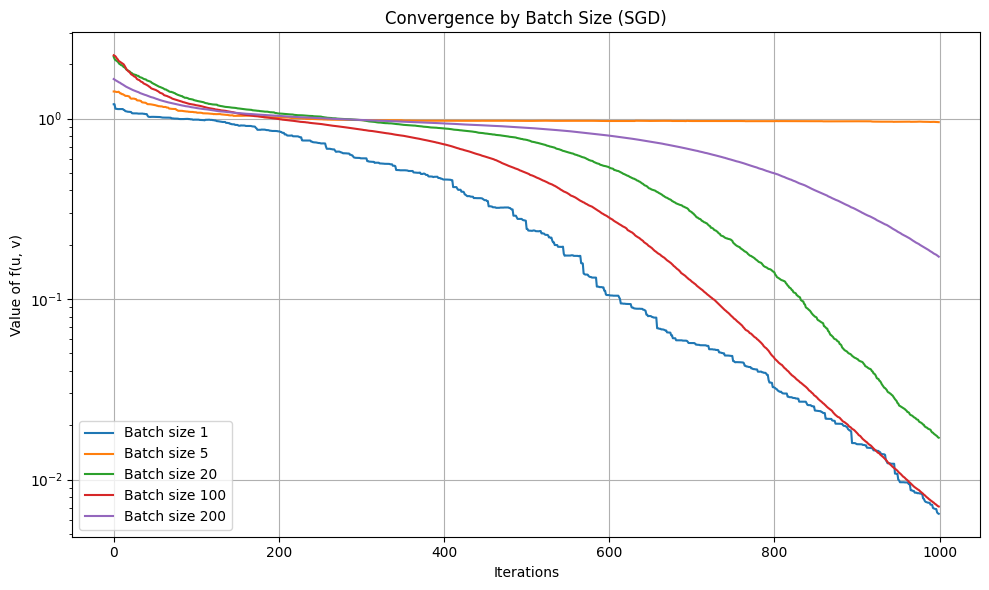

In [ ]:
# -----------------------------
# Visualization of results
# -----------------------------
plt.figure(figsize=(10, 6))

for bs in batch_sizes:
    plt.plot(results[bs], label=f"Batch size {bs}")

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Value of f(u, v)")
plt.title("Convergence by Batch Size (SGD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Une généralisation du problème d’approximation de rang 1 consiste à rechercher une approximation de rang (au plus) $r \leq \min(n_1, n_2)$, ce que l’on modélise par le problème :

$$\min_{U \in \mathbb{R}^{n_1 \times r}, V \in \mathbb{R}^{n_2 \times r}} \frac{1}{2n} \| UV^T - X \|^2 = \frac{1}{2n} \sum_{i=1}^{n_1} \sum_{j=1}^{n_2} ([UV^T]_{ij} - [X]_{ij})^2.$$

**Remarque 2.1 :** Toute matrice $A \in \mathbb{R}^{n_1 \times n_2}$ de rang au plus $r$ s’écrit sous la forme $A = \sum_{i=1}^{r} a_ib_i^T$ avec $a_i \in \mathbb{R}^{n_1}$ et $b_i \in \mathbb{R}^{n_2}$ pour tout $i = 1, \ldots, r$.


**Question 4 :**

**i) Adaptons le code de la question 3 pour implémenter la descente de gradient et le gradient stochastique sur le problème (4).**

Ce code implémente une approximation de rang $r$ pour une matrice donnée $X$ en utilisant la descente de gradient par lots et le gradient stochastique. L'objectif est de minimiser l'erreur quadratique entre la matrice $X$ et le produit de deux matrices de rang bas $U$ et $V$. Pour adapter le code de la question 3, nous avons modifié la structure des matrices $U$ et $V$ pour qu'elles soient de dimensions $n_1 \times r$ et $n_2 \times r$ respectivement, et avons ajusté les calculs du gradient et de la fonction objectif en conséquence. La classe `LowRankFactorization` encapsule le problème, tandis que les fonctions `gd_batch` et `sgd` réalisent les optimisations respectives. Les résultats sont visualisés pour comparer la convergence des deux méthodes.


In [ ]:
# -----------------------------
# Initialize parameters
# -----------------------------
np.random.seed(0)
n1, n2 = 10, 20
r = 3
n = n1 * n2

# -----------------------------
# Generate matrices U_bar and V_bar
# -----------------------------
U_bar = np.random.randn(n1, r)
V_bar = np.random.randn(n2, r)
X = U_bar @ V_bar.T  # X ∈ ℝⁿ¹ˣⁿ² of rank ≤ r

In [ ]:
# -----------------------------
# Class for low-rank factorization
# -----------------------------
class LowRankFactorization:
    def __init__(self, X, r):
        self.X = X
        self.n1, self.n2 = X.shape
        self.r = r
        self.n = self.n1 * self.n2

    def unpack(self, w):
        # Split the vector w into matrices U and V
        U = w[:self.n1 * self.r].reshape(self.n1, self.r)
        V = w[self.n1 * self.r:].reshape(self.n2, self.r)
        return U, V

    def fun(self, w):
        # Compute the objective function
        U, V = self.unpack(w)
        R = U @ V.T - self.X
        return np.sum(R ** 2) / (2 * self.n)

    def grad(self, w):
        # Compute the gradient of the objective function
        U, V = self.unpack(w)
        R = U @ V.T - self.X
        grad_U = R @ V / self.n
        grad_V = R.T @ U / self.n
        return np.concatenate([grad_U.ravel(), grad_V.ravel()])

In [ ]:
# -----------------------------
# Batch Gradient Descent
# -----------------------------
def gd_batch(w0, problem, stepsize=1.0, n_iter=300):
    w = w0.copy()
    obj_vals = []

    for _ in range(n_iter):
        obj_vals.append(problem.fun(w))
        grad = problem.grad(w)
        w -= stepsize * grad

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Stochastic Gradient Descent (SGD)
# -----------------------------
def sgd(w0, problem, stepsize=10.0, n_iter=10000):
    w = w0.copy()
    obj_vals = []

    for k in range(n_iter):
        i = np.random.randint(0, problem.n1)
        j = np.random.randint(0, problem.n2)

        U, V = problem.unpack(w)
        error = U[i] @ V[j] - problem.X[i, j]

        grad_U = np.zeros_like(U)
        grad_V = np.zeros_like(V)

        grad_U[i] = error * V[j] / problem.n
        grad_V[j] = error * U[i] / problem.n

        grad = np.concatenate([grad_U.ravel(), grad_V.ravel()])
        w -= stepsize * grad

        if k % 100 == 0:
            obj_vals.append(problem.fun(w))

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Initialization and execution of algorithms
# -----------------------------
w0 = np.random.randn(n1 * r + n2 * r)
problem = LowRankFactorization(X, r)

# Batch Gradient Descent
w_batch, obj_batch = gd_batch(w0, problem, stepsize=1.0, n_iter=300)

# Stochastic Gradient Descent
w_sgd, obj_sgd = sgd(w0, problem, stepsize=10.0, n_iter=10000)

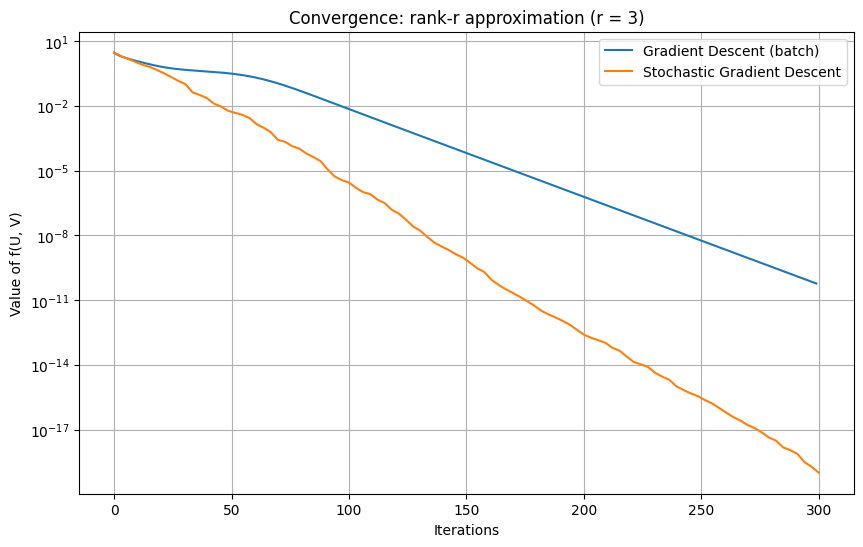

In [ ]:
# -----------------------------
# Visualization of results
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(obj_batch, label="Gradient Descent (batch)")
plt.plot(np.linspace(0, len(obj_batch), len(obj_sgd)), obj_sgd, label="Stochastic Gradient Descent")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Value of f(U, V)")
plt.title("Convergence: rank-r approximation (r = {})".format(r))
plt.grid(True)
plt.legend()
plt.show()


**ii) Comparons les deux variantes dans les cas suivants, avec $(n_1, n_2) = (10, 20)$ :**  
- **$X$ est une matrice de rang $r = 5$, où $r$ est la valeur utilisée dans (4).**  
- **$X$ est une matrice de rang $\min(n_1, n_2)$ et $r = 1$**


Ce code implémente une approximation de rang $r$ pour une matrice $X$ en utilisant la descente de gradient par lots et le gradient stochastique. Nous générons des matrices $U_{\text{bar}}$ et $V_{\text{bar}}$ pour créer une matrice $X$ de rang spécifié. Nous initialisons ensuite le problème de factorisation avec $X$ et $r$. Les optimisations sont effectuées par descente de gradient par lots et stochastique. Nous comparons la convergence des deux méthodes pour deux cas : une matrice $X$ de rang 5 avec $r = 5$, et une matrice $X$ de rang 10 avec $r = 1$. Enfin, nous visualisons les résultats pour analyser la performance des méthodes.

In [ ]:
# -----------------------------
# Case 1: X is a rank-5 matrix, r = 5
# -----------------------------
np.random.seed(0)
n1, n2 = 10, 20
r = 5

# Generate matrices U_bar and V_bar
U_bar = np.random.randn(n1, r)
V_bar = np.random.randn(n2, r)
X = U_bar @ V_bar.T  # X ∈ ℝⁿ¹ˣⁿ² of rank ≤ r

# Problem & initialization
problem = LowRankFactorization(X, r)
w0 = np.random.randn(n1 * r + n2 * r)

# Optimization
w_batch, obj_batch = gd_batch(w0, problem, stepsize=1.0, n_iter=300)
w_sgd, obj_sgd = sgd(w0, problem, stepsize=10.0, n_iter=10000)

In [ ]:
# -----------------------------
# Case 2: X is a rank-10 matrix, r = 1
# -----------------------------
np.random.seed(1)
n1, n2 = 10, 20
true_r = 10
r = 1  # Overly constrained approximation

# Generate matrices U_bar and V_bar
U_bar = np.random.randn(n1, true_r)
V_bar = np.random.randn(n2, true_r)
X = U_bar @ V_bar.T  # Rank-10 matrix

# Problem & initialization
problem = LowRankFactorization(X, r)
w0 = np.random.randn(n1 * r + n2 * r)

# Optimization
w_batch2, obj_batch2 = gd_batch(w0, problem, stepsize=1.0, n_iter=300)
w_sgd2, obj_sgd2 = sgd(w0, problem, stepsize=10.0, n_iter=10000)

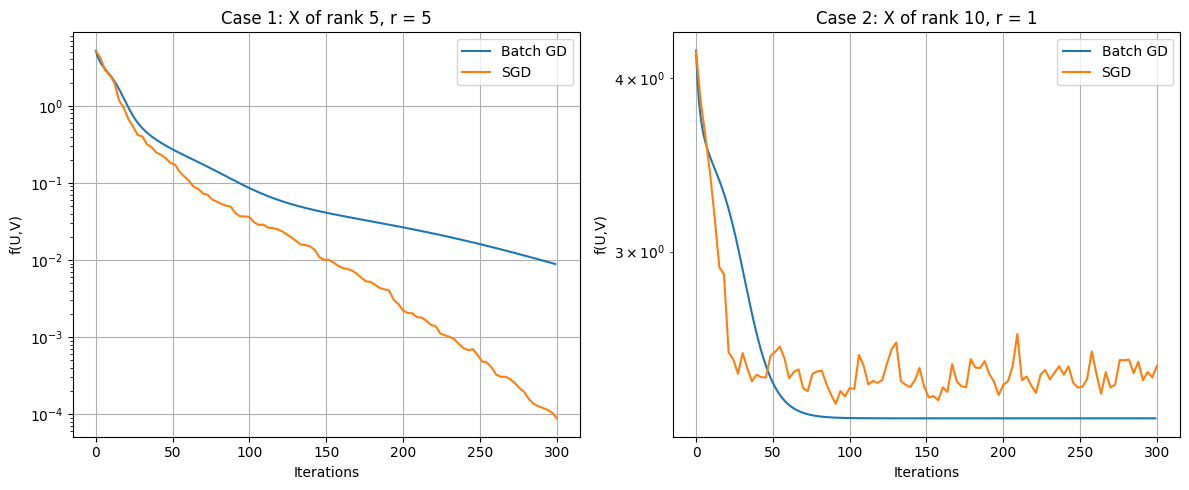

In [ ]:
# -----------------------------
# Visualization of results
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(obj_batch, label="Batch GD")
plt.plot(np.linspace(0, len(obj_batch), len(obj_sgd)), obj_sgd, label="SGD")
plt.yscale("log")
plt.title("Case 1: X of rank 5, r = 5")
plt.xlabel("Iterations")
plt.ylabel("f(U,V)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(obj_batch2, label="Batch GD")
plt.plot(np.linspace(0, len(obj_batch2), len(obj_sgd2)), obj_sgd2, label="SGD")
plt.yscale("log")
plt.title("Case 2: X of rank 10, r = 1")
plt.xlabel("Iterations")
plt.ylabel("f(U,V)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## **3. Factorisation matricielle régularisée**

On considère enfin le cas non pris en compte dans la question 4, où $r > 1$ dans le problème (4), mais la matrice $X$ est une version bruitée d’une matrice de rang 1. Dans ce cas, et pour promouvoir la robustesse, on rajoute un terme de régularisation au problème, et on obtient ainsi:

$$
\min_{U \in \mathbb{R}^{n_1 \times r}, V \in \mathbb{R}^{n_2 \times r}} \frac{1}{2n} \| UV^T - X \|^2_F + \frac{\lambda}{2} \| U \|^2_F + \frac{\lambda}{2} \| V \|^2_F,
$$

où $\lambda > 0$.

**Question 5**

**i) Adaptons le code de la question 4 pour implémenter la descente de gradient et le gradient stochastique sur le problème (5).**

Notre implémentation adapte le code de la question 4 pour résoudre un problème de factorisation de matrice de faible rang avec régularisation, en ajoutant un terme de régularisation pour promouvoir la robustesse. Nous avons généré une matrice $X$ comme une version bruitée d'une matrice de rang 1, puis utilisé la descente de gradient par lots et stochastique pour minimiser une fonction objectif régularisée. Nous avons testé différentes valeurs du paramètre de régularisation $\lambda$, y compris $\lambda = 0.1$, afin d'évaluer l'impact de la régularisation sur le rang des matrices résultantes. Cette approche permet de comparer les solutions obtenues pour différentes valeurs de $\lambda$, y compris $\lambda = 0$, afin d'évaluer l'efficacité de la régularisation.

In [ ]:
# -----------------------------
# Initialize parameters
# -----------------------------

# Set seed for reproducibility
np.random.seed(0)

n1, n2 = 10, 20
n = n1 * n2
r = 3  # r > 1

u_bar = np.random.randn(n1)
v_bar = np.random.randn(n2)
X_clean = np.outer(u_bar, v_bar)

# Add noise to simulate real data
noise = 0.1 * np.random.randn(n1, n2)
X = X_clean + noise

In [ ]:
# -----------------------------
# Class for low-rank factorization with regularization
# -----------------------------
class LowRankFactorizationReg:
    def __init__(self, X, r, lambd):
        # Initialize the class with matrix X, rank r, and regularization coefficient lambd
        self.X = X
        self.n1, self.n2 = X.shape
        self.r = r
        self.n = self.n1 * self.n2
        self.lambd = lambd  # regularization coefficient

    def unpack(self, w):
        # Split the vector w into matrices U and V
        U = w[:self.n1 * self.r].reshape(self.n1, self.r)
        V = w[self.n1 * self.r:].reshape(self.n2, self.r)
        return U, V

    def fun(self, w):
        # Compute the regularized objective function
        U, V = self.unpack(w)
        R = U @ V.T - self.X
        loss = np.sum(R ** 2) / (2 * self.n)
        reg = (self.lambd / 2) * (np.sum(U**2) + np.sum(V**2))
        return loss + reg

    def grad(self, w):
        # Compute the gradient of the regularized objective function
        U, V = self.unpack(w)
        R = U @ V.T - self.X
        grad_U = R @ V / self.n + self.lambd * U
        grad_V = R.T @ U / self.n + self.lambd * V
        return np.concatenate([grad_U.ravel(), grad_V.ravel()])

In [ ]:
# -----------------------------
# Optimization algorithms
# -----------------------------

def gd_batch(w0, problem, stepsize=1.0, n_iter=300):
    # Implement batch gradient descent
    w = w0.copy()
    obj_vals = []

    for _ in range(n_iter):
        obj_vals.append(problem.fun(w))
        grad = problem.grad(w)
        w -= stepsize * grad

    return w, np.array(obj_vals)

def sgd(w0, problem, stepsize=10.0, n_iter=10000):
    # Implement stochastic gradient descent
    w = w0.copy()
    obj_vals = []

    for k in range(n_iter):
        i = np.random.randint(0, problem.n1)
        j = np.random.randint(0, problem.n2)

        U, V = problem.unpack(w)
        error = U[i] @ V[j] - problem.X[i, j]

        grad_U = np.zeros_like(U)
        grad_V = np.zeros_like(V)
        grad_U[i] = (error * V[j] / problem.n) + problem.lambd * U[i]
        grad_V[j] = (error * U[i] / problem.n) + problem.lambd * V[j]

        grad = np.concatenate([grad_U.ravel(), grad_V.ravel()])
        w -= stepsize * grad

        if k % 100 == 0:
            obj_vals.append(problem.fun(w))

    return w, np.array(obj_vals)

In [ ]:
# -----------------------------
# Execution and visualization
# -----------------------------

# Regularization parameters
lambd = 0.1  # moderate regularization
problem = LowRankFactorizationReg(X, r=r, lambd=lambd)
w0 = np.random.randn(n1 * r + n2 * r)

# Run algorithms
w_gd, obj_gd = gd_batch(w0, problem, stepsize=1.0, n_iter=300)
w_sgd, obj_sgd = sgd(w0, problem, stepsize=10.0, n_iter=10000)

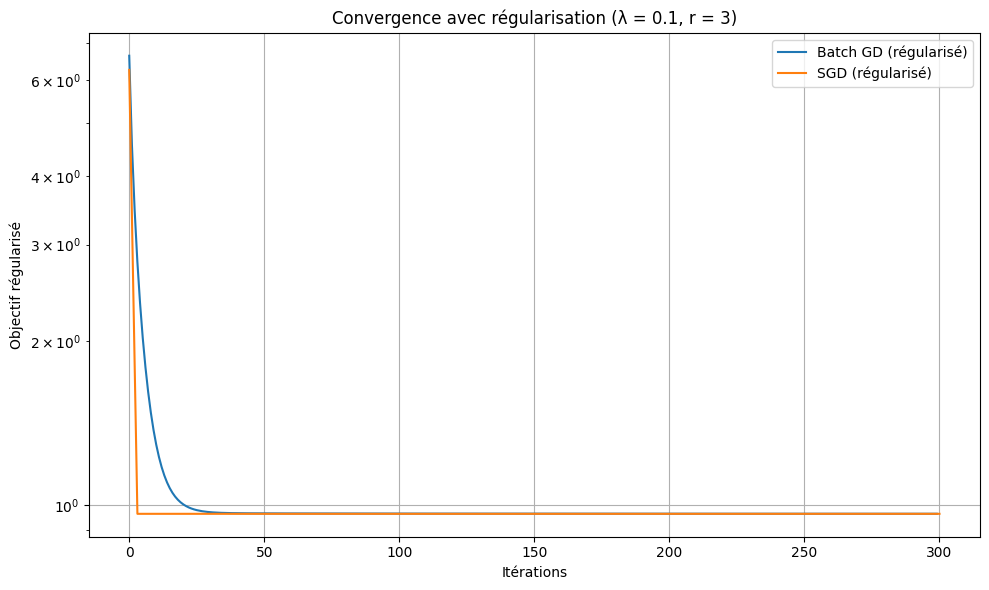

In [ ]:
# -----------------------------
# Visualization of results
# -----------------------------

plt.figure(figsize=(10, 6))
plt.plot(obj_gd, label="Batch GD (régularisé)")
plt.plot(np.linspace(0, len(obj_gd), len(obj_sgd)), obj_sgd, label="SGD (régularisé)")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Objectif régularisé")
plt.title(f"Convergence avec régularisation (λ = {lambd}, r = {r})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**ii) Générons une matrice $X = xz^T + \epsilon$, où $x$, $z$, et $\epsilon$ sont des vecteurs gaussiens tirés selon une loi ${N}(0, I)$. Comparer le rang des matrices obtenues en résolvant (5) avec ce choix de $X$ pour $r = 5$ et différentes valeurs de $\lambda$ (inclure $\lambda = 0$).**

Nous avons généré une matrice $X$ comme une version bruitée d'une matrice de rang 1 en utilisant des vecteurs gaussiens $x$, $z$, et un bruit $\epsilon$. Nous avons résolu le problème de factorisation de matrice de faible rang avec régularisation pour différentes valeurs de $\lambda$, y compris $\lambda = 0$. Pour chaque $\lambda$, nous avons calculé les valeurs singulières de la matrice reconstruite $UV^T$ pour déterminer le rang effectif. Cette approche permet d'évaluer l'impact de la régularisation sur le rang des matrices résultantes.

L'implémentation utilise la descente de gradient pour minimiser la fonction objectif. Nous avons testé les valeurs de $\lambda \in \{0.0, 10^{-3}, 10^{-2}, 10^{-1}, 1.0\}$ pour observer l'impact progressif de la régularisation.


In [ ]:
# -----------------------------
# Initialize parameters
# -----------------------------

np.random.seed(42)

# Define matrix dimensions and rank
n1, n2 = 10, 20
r = 5
n = n1 * n2

# Gaussian vectors
x = np.random.randn(n1)
z = np.random.randn(n2)
eps = np.random.randn(n1, n2)

# Matrix X = x zᵀ + noise
X = np.outer(x, z) + eps

In [ ]:
# -----------------------------
# Initialization and execution of algorithms
# -----------------------------

# Regularization parameters
lambdas = [0.0, 1e-3, 1e-2, 1e-1, 1.0]
singular_values = {}

for lambd in lambdas:
    print(f"λ = {lambd}")
    problem = LowRankFactorizationReg(X, r=r, lambd=lambd)
    w0 = np.random.randn(n1 * r + n2 * r)
    w_opt, _ = gd_batch(w0, problem, stepsize=1.0, n_iter=500)

    # Reconstruct U, V and UVᵀ
    U, V = problem.unpack(w_opt)
    UVt = U @ V.T

    # Singular values of UVᵀ
    s = np.linalg.svd(UVt, compute_uv=False)
    singular_values[lambd] = s

λ = 0.0
λ = 0.001
λ = 0.01
λ = 0.1
λ = 1.0


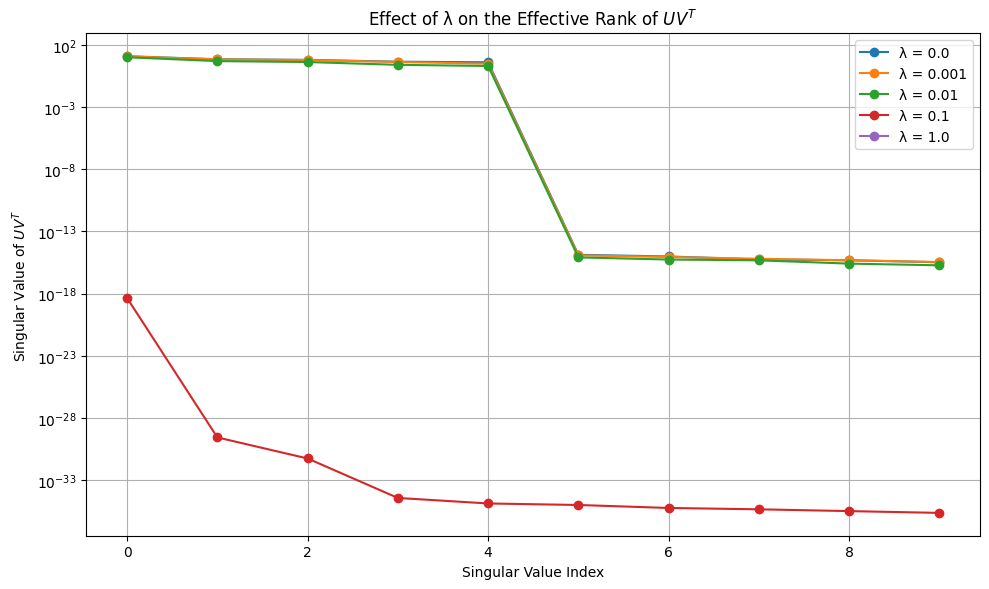

In [ ]:

# -----------------------------
# Visualization of results
# -----------------------------

plt.figure(figsize=(10, 6))

for lambd, s in singular_values.items():
    plt.plot(s, 'o-', label=f"λ = {lambd}")

plt.yscale("log")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value of $UV^T$")
plt.title("Effect of λ on the Effective Rank of $UV^T$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def effective_rank(s, threshold=1e-3):
    return np.sum(s / s[0] > threshold)

for lambd, s in singular_values.items():
    print(f"λ = {lambd} → rang effectif ≈ {effective_rank(s)}")

λ = 0.0 → rang effectif ≈ 5
λ = 0.001 → rang effectif ≈ 5
λ = 0.01 → rang effectif ≈ 5
λ = 0.1 → rang effectif ≈ 1
λ = 1.0 → rang effectif ≈ 0


<ipython-input-125-253a0b9772c2>:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(s / s[0] > threshold)


**iii) Peut-on déterminer $\lambda$ tel que la solution soit de rang 1 ? Si oui, la solution correspond-elle à $xz^T$ ?**

(voir rapport)

**iv) Les conclusions sont-elles différentes selon que l’on utilise le gradient stochastique ou la descente de gradient ?**

(voir rapport)